In [4]:
import numpy as np

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Lambda, Reshape, LeakyReLU, BatchNormalization, UpSampling2D ,Layer
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import metrics
from keras.callbacks import LearningRateScheduler, Callback

from sklearn.model_selection import train_test_split
from skimage.transform import resize

import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm
from scipy.misc import imresize

# from utils import compare_images

INPUT_DIM = (128,128,3)

CONV_FILTERS = [32,64,64, 64]
CONV_KERNEL_SIZES = [3,3,3,3]
CONV_STRIDES = [2,2,2,2]
CONV_ACTIVATIONS = ['relu','relu','relu','relu']
CONV_PADDINGS = ['same', 'same', 'same', 'same']

CONV_T_FILTERS = [64,64,32,3]
CONV_T_KERNEL_SIZES = [3,3,3,3]
CONV_T_STRIDES = [1,1,1,1]
CONV_T_ACTIVATIONS = ['relu','relu','relu','sigmoid']
CONV_T_PADDINGS = ['same','same','same','same']

RECONST_LOSS_FACTOR = 1e4

Z_DIM = 200

BATCH_SIZE = 32
LEARNING_RATE = 0.0005
KL_TOLERANCE = 0.5

In [5]:
from glob import glob
filenames = np.array(glob('./data/img_align_celeba/*.jpg'))


In [6]:
datagen_default = ImageDataGenerator(rescale=1./255, validation_split=0)

datagen_transformed = ImageDataGenerator(
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest', validation_split=0) 

gen_default = datagen_default.flow_from_directory('./data'
                                                    , target_size = INPUT_DIM[:2]
                                                    , batch_size = BATCH_SIZE
                                                    , shuffle = False
                                                    , class_mode = 'input', subset="training"
                                                )

gen_default_valid = datagen_default.flow_from_directory('./data'
                                                    , target_size = INPUT_DIM[:2]
                                                    , batch_size = BATCH_SIZE
                                                    , shuffle = False
                                                    , class_mode = 'input', subset="validation"
                                                )


Found 202599 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [7]:
sample_default = next(gen_default)
# sample_transformed = next(gen_transformed)
# compare_images(sample_default[0][0], sample_transformed[0][0])

In [8]:
const_img = sample_default[0][0].copy()

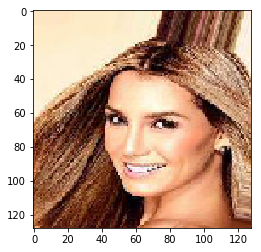

In [9]:
plt.imshow(const_img)

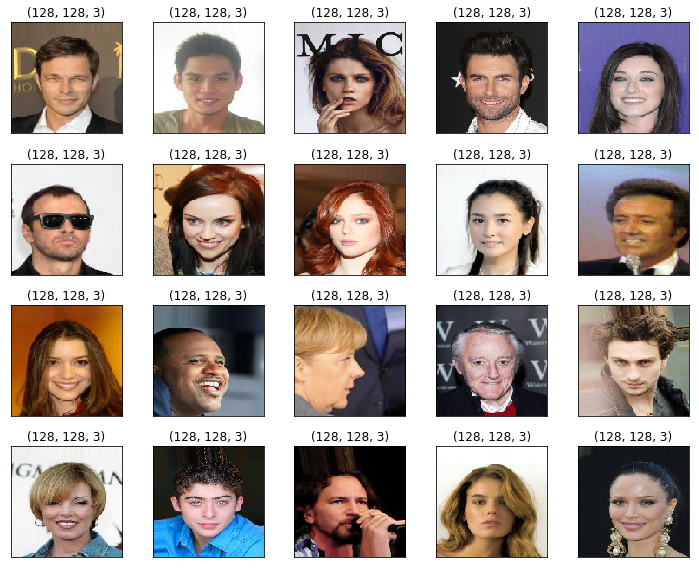

In [10]:
plt.figure(figsize=(10, 8))
for i in range(20):
    img = next(gen_default)[0][0]
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def convert_to_sigma(z_log_var):
    return K.exp(z_log_var / 2)







In [12]:
class VAE():
    def __init__(self):
        
        self.input_dim = INPUT_DIM
        self.z_dim = Z_DIM
        
        self.kl_tolerance = KL_TOLERANCE
        self.learning_rate = LEARNING_RATE
        self.reconst_loss_factor = RECONST_LOSS_FACTOR
        
        self.models = self._build()
        self.full_model = self.models[0]
        self.encoder = self.models[1]
        self.encoder_mu_log_var = self.models[2]
        self.decoder = self.models[3]

        self.completed_epochs = 0
        
    def _build(self):
        #### ENCODER
        input_img = Input(shape=INPUT_DIM, name='observation_input')
        x = LeakyReLU()(BatchNormalization()(Conv2D(filters = CONV_FILTERS[0], kernel_size = CONV_KERNEL_SIZES[0], strides = CONV_STRIDES[0], padding=CONV_PADDINGS[0], name='conv_layer_1')(input_img)))
        x = LeakyReLU()(BatchNormalization()(Conv2D(filters = CONV_FILTERS[1], kernel_size = CONV_KERNEL_SIZES[1], strides = CONV_STRIDES[1], padding=CONV_PADDINGS[1],name='conv_layer_2')(x)))
        x= LeakyReLU()(BatchNormalization()(Conv2D(filters = CONV_FILTERS[2], kernel_size = CONV_KERNEL_SIZES[2], strides = CONV_STRIDES[2], padding=CONV_PADDINGS[2],name='conv_layer_3')(x)))
        x= LeakyReLU()(BatchNormalization()(Conv2D(filters = CONV_FILTERS[3], kernel_size = CONV_KERNEL_SIZES[3], strides = CONV_STRIDES[3], padding=CONV_PADDINGS[3],name='conv_layer_4')(x)))

        shape_before_flattening = K.int_shape(x)
        
        x = Flatten()(x)

        z_mean = Dense(Z_DIM, name='mu')(x)
        z_log_var = Dense(Z_DIM, name='log_var')(x)

        z = Lambda(sampling, name='z')([z_mean, z_log_var])
        
        encoder = Model(input_img, z)
        encoder_mu_log_var = Model(input_img, (z_mean, z_log_var))
        
        #### DECODER
        decoder_input = Input(shape=(Z_DIM,), name='z_input')

        x = Dense(np.prod(shape_before_flattening[1:]), name='dense_layer')(decoder_input)
        x = Reshape(shape_before_flattening[1:], name='reshape')(x)
        
        x = LeakyReLU()(BatchNormalization()(Conv2D(filters = CONV_T_FILTERS[0], kernel_size = CONV_T_KERNEL_SIZES[0] , strides = CONV_T_STRIDES[0], padding=CONV_T_PADDINGS[0], name='deconv_layer_1')(UpSampling2D(size=2)(x))))
        x = LeakyReLU()(BatchNormalization()(Conv2D(filters = CONV_T_FILTERS[1], kernel_size = CONV_T_KERNEL_SIZES[1] , strides = CONV_T_STRIDES[1], padding=CONV_T_PADDINGS[1], name='deconv_layer_2')(UpSampling2D(size=2)(x))))
        x = LeakyReLU()(BatchNormalization()(Conv2D(filters = CONV_T_FILTERS[2], kernel_size = CONV_T_KERNEL_SIZES[2] , strides = CONV_T_STRIDES[2], padding=CONV_T_PADDINGS[2], name='deconv_layer_3')(UpSampling2D(size=2)(x))))
        x = Conv2D(filters = CONV_T_FILTERS[3], kernel_size = CONV_T_KERNEL_SIZES[3] , strides = CONV_T_STRIDES[3], padding=CONV_T_PADDINGS[3],  activation = 'sigmoid', name='deconv_layer_4')(UpSampling2D(size=2)(x))
        
        decoder = Model(decoder_input, x)
        z_decoded = decoder(z)
        
        ## LOSS

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return self.reconst_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss
        
        #### MODEL
        
        vae = Model(input_img, z_decoded)
        opti = Adam(lr=self.learning_rate)
        vae.compile(optimizer=opti, loss = vae_loss 
                    , metrics = [vae_r_loss, vae_kl_loss]
                   )
        
        #### CALLBACKS
        
        class CustomCallback(Callback):
            
            def __init__(self):
                self.epoch = 0

            def on_batch_end(self, batch, logs={}):  
                if batch % 100 == 0:
                    znew = np.random.normal(size = (1,Z_DIM))
                    reconst = decoder.predict(np.array(znew))[0]
                    plt.imsave('./images/img_' + str(self.epoch) + '_' + str(batch) + '.jpg', reconst)

            def on_epoch_begin(self, epoch, logs={}):
                self.epoch += 1
                print('LEARNING_RATE ' + str(K.eval(vae.optimizer.lr)))
                
                
        def step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=0.5, step_size=1):
            '''
            Wrapper function to create a LearningRateScheduler with step decay schedule.
            '''
            def schedule(epoch):
                new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
                
                return new_lr

            return LearningRateScheduler(schedule)
        

        self.custom_callback = CustomCallback()
        self.lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=1, step_size=1)
        

        return (vae, encoder, encoder_mu_log_var, decoder)
    
    

        
        
    def set_weights(self, filepath):
        self.full_model.load_weights(filepath)

    def train(self, gen_default, gen_default_valid): 
        

#             print('EPOCH ' + str(self.completed_epochs))
            
            self.full_model.fit_generator(gen_default
#                                           , steps_per_epoch = 5
                                          , shuffle = True
                                          , epochs = 5
                                          , workers = 4
                                          , use_multiprocessing = True
#                                           , validation_data = gen_default_valid
#                                           , validation_steps = 100
                                          , callbacks = [self.lr_sched, self.custom_callback]
                                         )
            
#             self.completed_epochs += 1


    
    def save_weights(self, filepath):
        self.full_model.save_weights(filepath)

In [13]:
vae = VAE()

In [14]:
vae.full_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv_layer_1 (Conv2D)           (None, 64, 64, 32)   896         observation_input[0][0]          
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv_layer_1[0][0]               
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv_layer

In [16]:
# vae.train(x_train)
print('reconst_loss_factor = ' + str(vae.reconst_loss_factor))
print('z_dim = ' + str(vae.z_dim))

vae.train(gen_default, gen_default_valid)

reconst_loss_factor = 10000.0
z_dim = 200
Epoch 1/5
LEARNING_RATE 0.0005
   8/6332 [..............................] - ETA: 2:45:03 - loss: 897.0435 - vae_r_loss: 715.9710 - vae_kl_loss: 181.0725

Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions


LEARNING_RATE 0.0005


  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
target = np.array([const_img, const_img])
pred = vae.full_model.predict(target)

# y_true_flat = K.flatten(target)
# y_pred_flat = K.flatten(pred)

# loss1 = K.mean(K.square(K.variable(target) - pred), axis = (1,2,3))
# loss2 = metrics.binary_crossentropy(K.variable(target), K.variable(pred))

# loss3 = K.square(y_true_flat - y_pred_flat)
# loss4 = metrics.binary_crossentropy(y_true_flat, y_pred_flat)


# print(loss1.shape)
# print(loss2.shape)
# print(loss3.shape)
# print(loss4.shape)

# print(K.eval(K.mean(loss1)))
# print(K.eval(K.mean(loss2)))
# print(K.eval(K.mean(loss3)))
# print(K.eval(K.mean(loss4)))

# print(K.eval(loss1))
# print(K.eval(loss2))
# print(K.eval(loss3))
# print(K.eval(loss4))

# loss.shape
# K.eval(K.mean(loss))

In [ ]:
plt.imshow(const_img)

In [ ]:
plt.imshow(pred[0])

In [ ]:
# display a 2D plot of the digit classes in the latent space
z_test = vae.encoder.predict_generator(gen_default, steps = 20)
plt.figure(figsize=(10, 10))
plt.scatter(z_test[:, 0] , z_test[:, 1] #, c=y_test, cmap='rainbow'
            , alpha=.5, s=1)
# plt.colorbar()
plt.axis('on')
plt.show()

In [ ]:
z_test = vae.encoder.predict_generator(gen_default, steps = 20)

mu = 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(Z_DIM):
    ax = fig.add_subplot(20, 10, i+1)
    
    ax.hist(z_test[:,i], density=True, bins = 100)
    ax.plot(x,stats.norm.pdf(x, mu, sigma))

plt.show()

In [ ]:
np.random.seed(1000)

znew = np.random.normal(size = (100,Z_DIM))

reconst = vae.decoder.predict(np.array(znew))

# display a 2D plot of the digit classes in the latent space
z_test = vae.encoder.predict_generator(gen_default, steps = 20)
plt.figure(figsize=(10, 10))
plt.scatter(z_test[:, 0] , z_test[:, 1] #, cmap='rainbow' , c=y_test
            , alpha=0.5, s=1)
# plt.colorbar()
plt.axis('on')

plt.plot(znew[0],znew[1], marker='o', markersize=3, color="red", linestyle = '')

plt.show()

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 101):
    
    ax = fig.add_subplot(10, 10, i)
#     ax.text(0.5, 0.5, str((2, 3, i)),
#            fontsize=18, ha='center')
    ax.imshow(reconst[i-1, :,:,:])
    ax.axis('off')
    
    

In [ ]:
batch_size = 16

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = INPUT_DIM[0]
figure = np.zeros((digit_size * n, digit_size * n, 3))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

feature_1 = 1
feature_2 = 2

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[0] * Z_DIM])
        z_sample[0][feature_1] = xi
        z_sample[0][feature_2] = yi
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, Z_DIM)
        x_decoded = vae.decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size,:] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()